In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [ ]:
#keras 사전훈련모델 불러오기 
feature_model = keras.applications.DenseNet201(input_shape=(224,224,3), weights="imagenet", include_top=False)
feature_model.trainable= False

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
feature_model.summary()

In [ ]:
feature_model.save('/content/drive/My Drive/Densnet_feature.h5')

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/audio_predict/train_image',
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 0,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/audio_predict/train_image',
                                                    subset = 'validation',
                                                    batch_size = batch_size,
                                                    seed = 0,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

Found 3818 images belonging to 2 classes.
Found 1272 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'0': 0, '1': 1}

In [ ]:
# 이미지 보강 2배
batch_step = (3818) // 32 #데이터 증폭 시켜 배치 스텝구하기
train_features = [] 
train_Y = [] 

for idx in tqdm(range(batch_step)):
  x, y = train_generator.next()
  train_Y.extend(y) 

  feature = feature_model.predict(x)
  train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape)
print(train_Y.shape)
print(train_Y)

100%|██████████| 119/119 [30:45<00:00, 15.51s/it]


(3808, 7, 7, 1920)
(3808, 2)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
valid_features = [] 
valid_Y = [] 

batch_step = (1281) // 32

for idx in tqdm(range(batch_step)):
    
    x, y = valid_generator.next()
    valid_Y.extend(y)
  
    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

In [ ]:
np.save('/content/drive/My Drive/train_features_Dense.npy',train_features )
np.save('/content/drive/My Drive/train_Y_Dense.npy',train_Y )

In [ ]:
np.save('/content/drive/My Drive/valid_features_Dense.npy',valid_features )
np.save('/content/drive/My Drive/valid_Y_Dense.npy',valid_Y )

In [ ]:
def build_model(feature_model):
    
    inputs = Input(shape=feature_model.output.shape[1:])
    
    x = GlobalAveragePooling2D()(inputs)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(2, activation='softmax', name='covid_output')(x)

    model = Model(inputs=inputs,
                 outputs = outputs)
    
    init_lr = 0.0001
    opt = Adam(lr=init_lr)
    model.compile(optimizer=opt, 
                  loss= 'categorical_crossentropy',
                  metrics='accuracy')
    
    
    return model

In [ ]:
model = build_model(feature_model)


model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 7, 7, 1920)]      0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               245888    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
covid_output (Dense)         (None, 2)                 258       
Total params: 253,826
Trainable params: 249,986
Non-trainable params: 3,840
____________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = '/content/drive/My Drive/check.h5'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)

es = EarlyStopping(patience=20, verbose=1)
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 100,
                    batch_size = 32,
                    callbacks=[es,cp])
model.summary()

Epoch 1/100
117/119 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6886
Epoch 00001: val_accuracy improved from -inf to 0.72406, saving model to /content/drive/My Drive/check.h5
119/119 [==============================] - 2s 16ms/step - loss: 0.6757 - accuracy: 0.6901 - val_loss: 0.5742 - val_accuracy: 0.7241
Epoch 2/100
115/119 [===========================>..] - ETA: 0s - loss: 0.5350 - accuracy: 0.7443
Epoch 00002: val_accuracy improved from 0.72406 to 0.72484, saving model to /content/drive/My Drive/check.h5
119/119 [==============================] - 1s 10ms/step - loss: 0.5345 - accuracy: 0.7463 - val_loss: 0.5520 - val_accuracy: 0.7248
Epoch 3/100
117/119 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.7746
Epoch 00003: val_accuracy did not improve from 0.72484
119/119 [==============================] - 1s 10ms/step - loss: 0.4752 - accuracy: 0.7755 - val_loss: 0.5701 - val_accuracy: 0.7083
Epoch 4/100
114/119 [======================

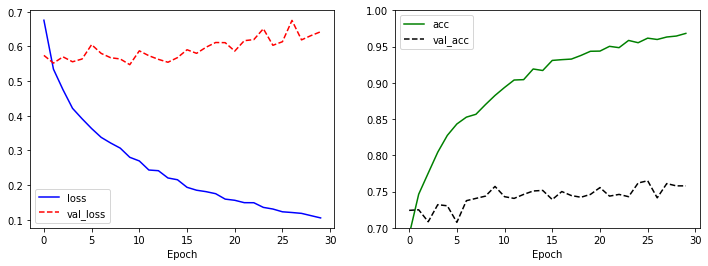

In [ ]:
    import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
 
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'acc')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_acc')
plt.xlabel('Epoch')
plt.ylim([0.7, 1])
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(valid_features, valid_Y)
print('Test accuracy: ', results[1])

40/40 [==============================] - 0s 7ms/step - loss: 0.6425 - accuracy: 0.7579
Test accuracy:  0.7578616142272949


In [ ]:
model.save('/content/drive/My Drive/Densenet_model!.h5')